## Music Genre Classification using a CNN with MFCC, OSC and DFB


### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Data/genres_original"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Data/genres_original


In [ ]:
import tensorflow as tf
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
seed = 42
import pandas as pd
import librosa
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow import keras as tfk
from keras import layers as tfkl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

### Load and preprocess the dataset

GTZAN dataset preprocessing. The 30-second audio files are downsampled to **16 kHz**
and converted to mono. Each track is then split into **3-second segments**, so in
principle 1,000 original tracks would yield 10,000 segments (30 / 3 per track).

In practice, a small number of audio files are slightly shorter or corrupted, so
the final number of valid 3-second segments is **9,990** instead of 10,000.
These segments, together with their genre labels, are used as input for feature
extraction and model training.


In [ ]:
sample_rate = 16000
path = "/gdrive/My Drive/Data/genres_original"
segment_duration = 3
audio_data = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            audio_path = os.path.join(root, file)
            audio, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
            num_segments = len(audio) // (sample_rate * segment_duration)
            for i in range(num_segments):
                start = i * sample_rate * segment_duration
                end = (i + 1) * sample_rate * segment_duration
                segment = audio[start:end]
                audio_data.append(segment)
print(len(audio_data))

9990


The labels are extracted from a CSV file (`features_3_sec.csv`) that contains
pre-computed features and the **genre label** for each 3-second segment.
From this file we read the last column, which stores the categorical labels,
and inspect the **class distribution** (number of segments per genre).

This allows us to check that:
- all 10 genres are present
- there are no obvious issues with missing labels
- the dataset is reasonably balanced across classes.


In [ ]:
csv_path = "/gdrive/My Drive/Data/features_3_sec.csv"  # Percorso al file CSV

df = pd.read_csv(csv_path)
labels = df.iloc[:,-1]
unique, count = np.unique(labels, return_counts=True)

print("Total Labels",labels.shape[0])
for i,u in enumerate(unique):
    print(f'{unique[i]}: {count[i]} samples')

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

Total Labels 9990
blues: 1000 samples
classical: 998 samples
country: 997 samples
disco: 999 samples
hiphop: 998 samples
jazz: 1000 samples
metal: 1000 samples
pop: 1000 samples
reggae: 1000 samples
rock: 998 samples


### Feature extraction from the audio

For each 3-second audio segment we compute three families of features:

- **MFCC** (Mel-Frequency Cepstral Coefficients)
- **DFB** (Decorrelated Filter Bank features)
- **OSC** (Octave-based Spectral Contrast)

For each feature type and each frequency band we compute **mean** and **variance**
over time. These statistics are stacked into a compact **6×7 matrix**:
6 rows = (mean, variance) × 3 feature families  
7 columns = frequency bands.

Each 6×7 matrix is then reshaped to 6×7×1 and treated as a small 2D input image
for the Convolutional Neural Network (CNN).


In [ ]:
n_bands=7
sample_rate=16000

In [ ]:
def decorrelated_filter_bank(signal, sample_rate, n_bands):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=n_bands)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    dfb = np.diff(log_mel_spectrogram, axis=0)
    return dfb

In [ ]:
audio_features=[]
for audio in audio_data:
    features=[]
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_bands)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_variance = np.var(mfcc, axis=1)

    spec_power = np.abs(librosa.stft(audio))**2
    osc = librosa.feature.spectral_contrast(S=spec_power, sr=sr)
    osc_mean = np.mean(osc, axis=1)
    osc_variance = np.var(osc, axis=1)

    dfb = decorrelated_filter_bank(audio, sr, n_bands+1)
    dfb_mean = np.mean(dfb, axis=1)
    dfb_variance = np.var(dfb, axis=1)

    features.append(mfcc_mean.tolist())
    features.append(mfcc_variance.tolist())
    features.append(osc_mean.tolist())
    features.append(osc_variance.tolist())
    features.append(dfb_mean.tolist())
    features.append(dfb_variance.tolist())
    audio_features.append(features)

In [ ]:
audio_features= np.array(audio_features)

### Train, Validation and Test Sets

The dataset is divided into three subsets:

- a **training set**, used to fit the model parameters
- a **validation set**, used for model selection and early stopping
- a **test set**, used only at the end to evaluate the final performance on unseen data

First, we split the data into a combined *train+validation* set and a separate
test set (20% of the segments, stratified by label).  
Then, we further split the *train+validation* set into:

- a **training set**
- a **validation set** with approximately the same size as the test set,

while preserving the original class distribution at each step (stratified splits).


In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
M_train_val, M_test, y_train_val, y_test = train_test_split(
    audio_features,
    labels,
    test_size = 0.2,
    random_state=seed,
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
M_train, M_val, y_train, y_val = train_test_split(
    M_train_val,
    y_train_val,
    test_size = len(M_test),
    random_state=seed,
    stratify = y_train_val
)

### Inspection of dataset shapes

In [ ]:
print("Training set data and label shape:", M_train.shape, y_train.shape)
print("Validation set data and label shape:", M_val.shape, y_val.shape)
print("Test set data and label shape:", M_test.shape, y_test.shape)

Training set data and label shape: (5994, 6, 7) (5994,)
Validation set data and label shape: (1998, 6, 7) (1998,)
Test set data and label shape: (1998, 6, 7) (1998,)


### Reshaping for CNN input

Before feeding the data to the CNN, we add a singleton channel dimension so that
each sample has shape (6, 7, 1), as expected by 2D convolutional layers.

In [ ]:
M_train= np.expand_dims(M_train , axis=-1)
M_val= np.expand_dims(M_val, axis=-1)
M_test= np.expand_dims( M_test, axis=-1)
y_train= np.expand_dims(y_train , axis=-1)
y_val= np.expand_dims(y_val, axis=-1)
y_test= np.expand_dims(y_test, axis=-1)
print("Training set data and label shape:", M_train.shape, y_train.shape)
print("Validation set data and label shape:", M_val.shape, y_val.shape)
print("Test set data and label shape:", M_test.shape, y_test.shape)

Training set data and label shape: (5994, 6, 7, 1) (5994, 1)
Validation set data and label shape: (1998, 6, 7, 1) (1998, 1)
Test set data and label shape: (1998, 6, 7, 1) (1998, 1)


In [ ]:
print('Check occurrences distribution over the 3 sets classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_val, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_test, columns=['class'])['class'].value_counts())

Check occurrences distribution over the 3 sets classes:
class
0    600
8    600
5    600
7    600
6    600
3    599
4    599
1    599
2    599
9    598
Name: count, dtype: int64
class
5    200
8    200
0    200
6    200
9    200
1    200
3    200
7    200
4    199
2    199
Name: count, dtype: int64
class
0    200
8    200
5    200
3    200
7    200
4    200
6    200
9    200
2    199
1    199
Name: count, dtype: int64


In [ ]:
# Convert textual labels to numeric and categorical format using one-hot encoding
# We have the unique values in the ndarray "unique"
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

### CNN Model and Training

The CNN architecture consists of two **Conv2D–BatchNorm–ReLU** blocks, followed
by max pooling and dropout for regularization. The convolutional stack is then
flattened and passed to a fully connected **dense layer** with L2 regularization,
followed by the final **softmax output layer** over the 10 genres.

Key components:
- 2D convolutions on the 6×7×1 feature matrices
- Batch Normalization and ReLU activations
- MaxPooling2D to reduce spatial dimensions
- Dropout to mitigate overfitting
- Dense classifier layer with L2 regularization
- Softmax output with 10 units (one per genre)


In [ ]:
# Define key model parameters
input_shape = M_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 64               # Batch size for training
epochs = 1000          # Number of training epochs
learning_rate = 1e-3

In [ ]:
def build_CNN(input_shape, output_shape, seed=42):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    # First layer
    conv1 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        name='conv1'
    )(input_layer)

    batchnorm1 = tfkl.BatchNormalization()(conv1)
    activation1 = tfkl.Activation('relu')(batchnorm1)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(3, 3),
        name='mp1'
    )(activation1)

    # Second layer
    conv2 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        name='conv2'
    )(pool1)

    batchnorm2 = tfkl.BatchNormalization()(conv2)
    activation2 = tfkl.Activation('relu')(batchnorm2)

    pool2 = tfkl.MaxPooling2D(
        pool_size=(2, 2),
        name='mp2'
    )(activation2)

    flattening_layer = tfkl.Flatten(
        name='flatten'
    )(pool2)

    dropout = tfkl.Dropout(0.4)(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=128,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        name="dense",
    )(dropout)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    return model


In [ ]:
# Build the CNN model and display its summary
model = build_CNN(input_shape, output_shape, seed=seed)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6, 7, 1)]         0         
                                                                 
 conv1 (Conv2D)              (None, 6, 7, 128)         1280      
                                                                 
 batch_normalization_52 (Ba  (None, 6, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 activation_52 (Activation)  (None, 6, 7, 128)         0         
                                                                 
 mp1 (MaxPooling2D)          (None, 2, 2, 128)         0         
                                                                 
 conv2 (Conv2D)              (None, 2, 2, 128)         147584    
                                                               

In [ ]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=30, min_lr=1e-7, mode='max')
]

In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
# Train the model and save its history
history = model.fit(
    x=M_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(M_val, y_val),
    callbacks=callbacks
).history

Epoch 1/1000
94/94 [==============================] - 2s 8ms/step - loss: 3.3608 - accuracy: 0.1882 - val_loss: 3.0877 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 2/1000
94/94 [==============================] - 1s 7ms/step - loss: 2.7806 - accuracy: 0.2629 - val_loss: 2.5471 - val_accuracy: 0.3003 - lr: 0.0010
Epoch 3/1000
94/94 [==============================] - 1s 5ms/step - loss: 2.3613 - accuracy: 0.3278 - val_loss: 2.2186 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 4/1000
94/94 [==============================] - 1s 6ms/step - loss: 2.0999 - accuracy: 0.3709 - val_loss: 2.0721 - val_accuracy: 0.3579 - lr: 0.0010
Epoch 5/1000
94/94 [==============================] - 1s 8ms/step - loss: 1.9605 - accuracy: 0.3819 - val_loss: 1.8848 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 6/1000
94/94 [==============================] - 1s 8ms/step - loss: 1.8535 - accuracy: 0.4037 - val_loss: 1.7903 - val_accuracy: 0.4209 - lr: 0.0010
Epoch 7/1000
94/94 [==============================] - 1s 8ms/step - lo

In [ ]:
model.save('CNN_features')
del model

In [ ]:
# Load the saved CNN model
model = tfk.models.load_model('CNN_features')

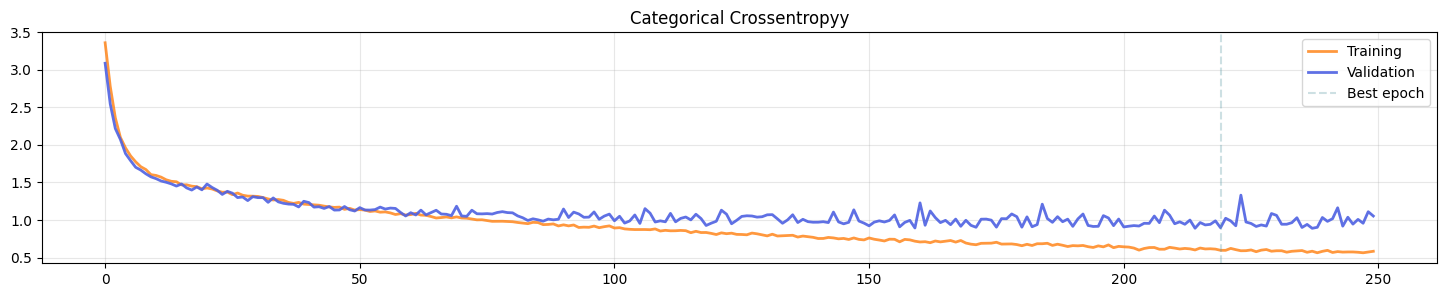

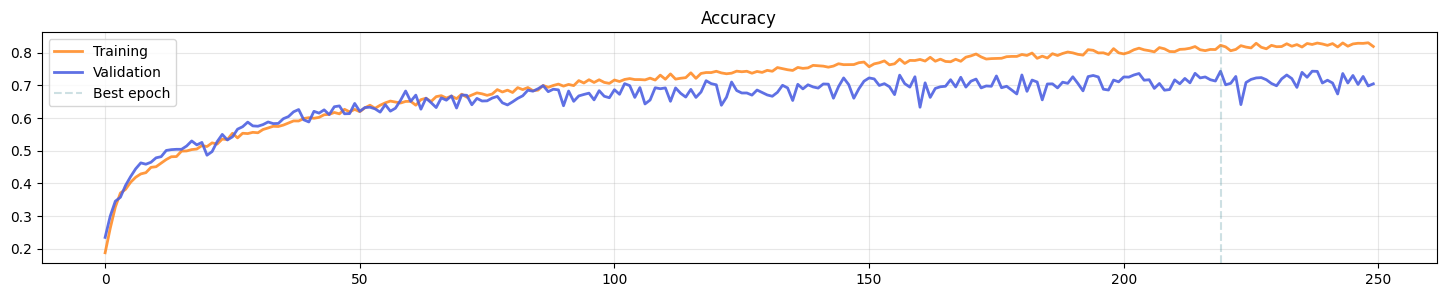

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#4D61E2', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropyy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#4D61E2', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Performance on Test Set

We evaluate the trained CNN on the held-out test set, reporting accuracy,
precision, recall and F1-score, as well as the confusion matrix to inspect
common misclassifications across genres.

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(M_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1998, 10)


Accuracy: 0.7497
Precision: 0.7542
Recall: 0.7497
F1: 0.7476


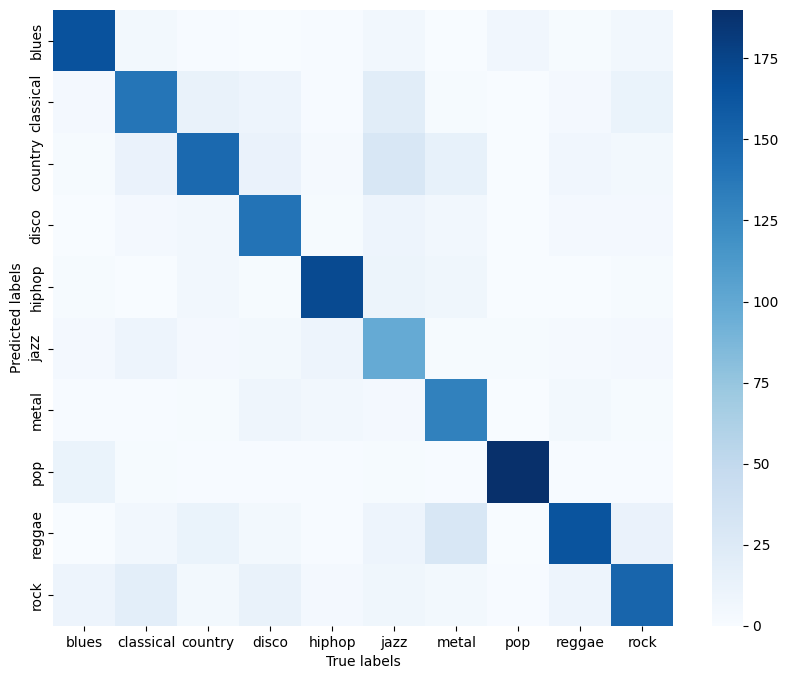

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
label_map= {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

sns.heatmap(cm.T, xticklabels=list(label_map.values()), yticklabels=list(label_map.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()